In [23]:
# Import ML libraries
import pycaret
import xgboost
import numpy as np
import shap

# Snowpark for Python
from snowflake.snowpark.session import Session
import snowflake.snowpark.types as T
import snowflake.snowpark.functions as F
import snowflake.snowpark as snowpark
from snowflake.snowpark.functions import datediff, to_date, col, expr

# Import Misc
import json
import pandas as pd
from pycaret.classification import setup, compare_models, tune_model, plot_model, interpret_model, create_model


In [2]:
# Create Snowflake Session object
connection_parameters = json.load(open(".\connection.json"))
session = Session.builder.configs(connection_parameters).create()

In [3]:
# Connecting to the correct table
tableName = 'PURCHASE_ORDER_HISTORY'
dataframe = session.table(tableName)

# Calculation to find the lag between Planned Delivery from Actual Delivery
dataframe = dataframe.withColumn("target_feature",
                                    datediff('day', 
                                            col("DELIVERY_DATE_ML"), 
                                            col("FIRST_GR_POSTING_DATE_ML")))


# Example: Selecting specific columns
# This selects only a subset of columns. Adjust the column names as needed.
filtered_dataframe = dataframe.select(
    col("PURCHASE_DOCUMENT_ITEM_ID"), # ID for purchase order
    col("CREATE_DATE_ML"),            # day purchase order was created
    col("COMPANY_CODE_ID"),           # copmany w/in INVISTA making purchase
    col("VENDOR_ID"),                 # ID of the vendor "we" are purchasing from
    col("POSTAL_CD"),                 # postal code associated w company code ID
    col("MATERIAL_ID"),               # ID of material being purchase
    col("SUB_COMMODITY_DESC"),        # description of sub commodity
    col("MRP_TYPE_ID"),               # determined if material is reordered manually or automatically
    col("PLANT_ID"),                  # ID of plant making purchase
    col("REQUESTED_DELIVERY_DATE_ML"),# delivery date from requisition
    col("INBOUND_DELIVERY_ID"),       # ID for delivery
    col("INBOUND_DELIVERY_ITEM_ID"),  # ID of item w/in delivery
    col("PLANNED_DELIVERY_DAYS"),     # Amount of days expected to take
    col("FIRST_GR_POSTING_DATE_ML"),  # expected delivery date      
    col("target_feature")             # Lag between Planned Delivery from Actual Delivery 
)


# Print a sample of the filtered dataframe to standard output.
filtered_dataframe.show()

# Optionally, you might want to filter rows based on some conditions
# Example: Filtering out rows where FIRST_GR_POSTING_DATE_ML is NULL
filtered_dataframe = filtered_dataframe.filter(col("FIRST_GR_POSTING_DATE_ML").is_not_null())

# Show the DataFrame after filtering
filtered_dataframe.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"PURCHASE_DOCUMENT_ITEM_ID"  |"CREATE_DATE_ML"  |"COMPANY_CODE_ID"  |"VENDOR_ID"  |"POSTAL_CD"  |"MATERIAL_ID"  |"SUB_COMMODITY_DESC"                    |"MRP_TYPE_ID"  |"PLANT_ID"  |"REQUESTED_DELIVERY_DATE_ML"  |"INBOUND_DELIVERY_ID"  |"INBOUND_DELIVERY_ITEM_ID"  |"PLANNED_DELIVERY_DAYS"  |"FIRST_GR_POSTING_DATE_ML"  |"TARGET_FEATURE"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [4]:
# Assuming 'filtered_dataframe' is the DataFrame you've prepared in Snowflake
# Convert the Snowpark DataFrame to a Pandas DataFrame with consideration for NULL values

# Convert DataFrame to Pandas, handling NULL values by allowing float conversion
df = filtered_dataframe.fillna(0).to_pandas()  # This replaces NULL with 0 before conversion

Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "CREATE_DATE_ML", Type: DateType(), Input Value: 0, Type: <class 'int'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "COMPANY_CODE_ID", Type: StringType(16777216), Input Value: 0, Type: <class 'int'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "VENDOR_ID", Type: StringType(16777216), Input Value: 0, Type: <class 'int'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "POSTAL_CD", Type: StringType(16777216), Input Value: 0, Type: <class 'int'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "SUB_COMMODITY_DESC", Type: StringType(16777216), Input Value: 0, Type: <class 'int'>
Input value type doesn't match the target column data type, this replacement was skipped. 

In [5]:
df.head()

,PURCHASE_DOCUMENT_ITEM_ID,CREATE_DATE_ML,COMPANY_CODE_ID,VENDOR_ID,POSTAL_CD,MATERIAL_ID,SUB_COMMODITY_DESC,MRP_TYPE_ID,PLANT_ID,REQUESTED_DELIVERY_DATE_ML,INBOUND_DELIVERY_ID,INBOUND_DELIVERY_ITEM_ID,PLANNED_DELIVERY_DAYS,FIRST_GR_POSTING_DATE_ML,TARGET_FEATURE
0,30,2020-09-14,US10,8010000984,60045-5202,0,Piping & Tubing,0,4071,2020-09-18,185203955,20,0.0,2020-09-16,-2
1,30,2020-09-14,CA10,8010098271,L5T 2W6,0,Office Supplies,0,4036,2020-10-02,0,0,21.0,2020-09-21,-11
2,10,2020-09-14,US10,8010008012,29169-6713,0,"Building, Construction Services",0,4014,2020-09-18,0,0,0.0,2020-10-19,31
3,10,2020-09-14,CA10,V4064,77905,2100013177,"Additives, Colorants & Catalysts",1,4036,2020-10-02,185209985,10,14.0,2020-09-30,-2
4,10,2020-09-14,US39,8010004480,13148-1590,1100272935,Pumps & Compressors,1,4120,2020-11-13,0,0,60.0,2020-12-14,31


In [6]:
df_filtered = df[(df['TARGET_FEATURE'] <= 100) & (df['TARGET_FEATURE'] >= -100)]


In [7]:
df_filtered.head()

,PURCHASE_DOCUMENT_ITEM_ID,CREATE_DATE_ML,COMPANY_CODE_ID,VENDOR_ID,POSTAL_CD,MATERIAL_ID,SUB_COMMODITY_DESC,MRP_TYPE_ID,PLANT_ID,REQUESTED_DELIVERY_DATE_ML,INBOUND_DELIVERY_ID,INBOUND_DELIVERY_ITEM_ID,PLANNED_DELIVERY_DAYS,FIRST_GR_POSTING_DATE_ML,TARGET_FEATURE
0,30,2020-09-14,US10,8010000984,60045-5202,0,Piping & Tubing,0,4071,2020-09-18,185203955,20,0.0,2020-09-16,-2
1,30,2020-09-14,CA10,8010098271,L5T 2W6,0,Office Supplies,0,4036,2020-10-02,0,0,21.0,2020-09-21,-11
2,10,2020-09-14,US10,8010008012,29169-6713,0,"Building, Construction Services",0,4014,2020-09-18,0,0,0.0,2020-10-19,31
3,10,2020-09-14,CA10,V4064,77905,2100013177,"Additives, Colorants & Catalysts",1,4036,2020-10-02,185209985,10,14.0,2020-09-30,-2
4,10,2020-09-14,US39,8010004480,13148-1590,1100272935,Pumps & Compressors,1,4120,2020-11-13,0,0,60.0,2020-12-14,31


In [8]:
# Define bins from -100 to 100, with each bin covering a 20-day range
bins = list(range(-100, 101, 10))  # This creates bins at every 20 units from -100 to 100

# Create labels for these bins
labels = [f'{i} to {i+9}' for i in bins[:-1]]  # Exclude the last bin edge for labeling

# Categorize the days into bins
df_filtered['time_slot'] = pd.cut(df_filtered['TARGET_FEATURE'], bins=bins, labels=labels, right=False)

In [9]:
df_filtered = df_filtered.dropna(subset=['time_slot'])

In [10]:
df_filtered['time_slot'].value_counts()

0 to 9         486613
-10 to -1      265379
10 to 19        72645
-20 to -11      37255
20 to 29        34681
30 to 39        18171
-30 to -21      14881
40 to 49        11736
50 to 59         7645
-40 to -31       6748
60 to 69         5910
70 to 79         4409
-50 to -41       4226
80 to 89         3735
-60 to -51       2917
90 to 99         2642
-70 to -61       2406
-80 to -71       1778
-90 to -81       1541
-100 to -91      1093
Name: time_slot, dtype: int64

In [11]:
df_filtered.head()

,PURCHASE_DOCUMENT_ITEM_ID,CREATE_DATE_ML,COMPANY_CODE_ID,VENDOR_ID,POSTAL_CD,MATERIAL_ID,SUB_COMMODITY_DESC,MRP_TYPE_ID,PLANT_ID,REQUESTED_DELIVERY_DATE_ML,INBOUND_DELIVERY_ID,INBOUND_DELIVERY_ITEM_ID,PLANNED_DELIVERY_DAYS,FIRST_GR_POSTING_DATE_ML,TARGET_FEATURE,time_slot
0,30,2020-09-14,US10,8010000984,60045-5202,0,Piping & Tubing,0,4071,2020-09-18,185203955,20,0.0,2020-09-16,-2,-10 to -1
1,30,2020-09-14,CA10,8010098271,L5T 2W6,0,Office Supplies,0,4036,2020-10-02,0,0,21.0,2020-09-21,-11,-20 to -11
2,10,2020-09-14,US10,8010008012,29169-6713,0,"Building, Construction Services",0,4014,2020-09-18,0,0,0.0,2020-10-19,31,30 to 39
3,10,2020-09-14,CA10,V4064,77905,2100013177,"Additives, Colorants & Catalysts",1,4036,2020-10-02,185209985,10,14.0,2020-09-30,-2,-10 to -1
4,10,2020-09-14,US39,8010004480,13148-1590,1100272935,Pumps & Compressors,1,4120,2020-11-13,0,0,60.0,2020-12-14,31,30 to 39


In [12]:
# Remove the original 'target_feature' column from the DataFrame
df_filtered = df_filtered.drop(columns=['TARGET_FEATURE'])


In [13]:
# Setup the PyCaret environment for classification
clf_setup = setup(data=df_filtered, target='time_slot', session_id=123, use_gpu=True, n_jobs=10)


,Description,Value
0,Session id,123
1,Target,time_slot
2,Target type,Multiclass
3,Target mapping,"-10 to -1: 0, -100 to -91: 1, -20 to -11: 2, -30 to -21: 3, -40 to -31: 4, -50 to -41: 5, -60 to -51: 6, -70 to -61: 7, -80 to -71: 8, -90 to -81: 9, 0 to 9: 10, 10 to 19: 11, 20 to 29: 12, 30 to 39: 13, 40 to 49: 14, 50 to 59: 15, 60 to 69: 16, 70 to 79: 17, 80 to 89: 18, 90 to 99: 19"
4,Original data shape,"(986411, 15)"
5,Transformed data shape,"(986411, 15)"
6,Transformed train set shape,"(690487, 15)"
7,Transformed test set shape,"(295924, 15)"
8,Numeric features,6
9,Categorical features,8


In [14]:
# List of model IDs you're interested in
# 'rf' - Random Forest, 'et' - Extra Trees, 'dt' - Decision Tree
model_ids = ['rf', 'et', 'dt']

# Use compare_models but only for the specified models
best_model = compare_models(include=model_ids, fold=5, round=4)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7724,0.9344,0.7724,0.7673,0.7612,0.6460,0.6494,78.8840
dt,Decision Tree Classifier,0.7341,0.8148,0.7341,0.7338,0.7339,0.6060,0.6060,14.3240
et,Extra Trees Classifier,0.1528,0.1861,0.1528,0.1512,0.1510,0.1273,0.1278,54.3520


In [14]:
rf_model = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7816,0.9390,0.7816,0.7769,0.7715,0.6612,0.6643
1,0.7790,0.9381,0.7790,0.7739,0.7685,0.6570,0.6601
2,0.7776,0.9378,0.7776,0.7722,0.7667,0.6544,0.6577
3,0.7813,0.9391,0.7813,0.7761,0.7709,0.6608,0.6639
4,0.7815,0.9390,0.7815,0.7770,0.7713,0.6610,0.6641
5,0.7825,0.9394,0.7825,0.7773,0.7720,0.6625,0.6657
6,0.7804,0.9390,0.7804,0.7761,0.7699,0.6592,0.6623
7,0.7822,0.9394,0.7822,0.7777,0.7719,0.6619,0.6651
8,0.7802,0.9382,0.7802,0.7753,0.7699,0.6590,0.6621


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

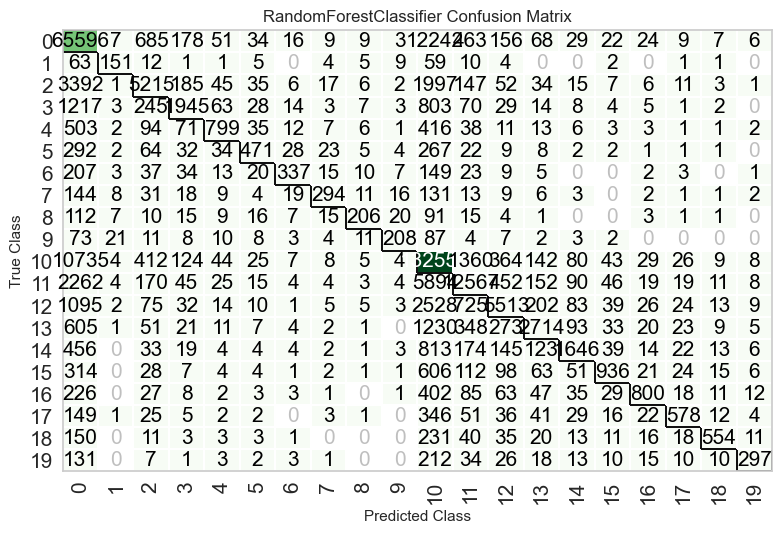

In [15]:
plot_model(rf_model, plot='confusion_matrix')


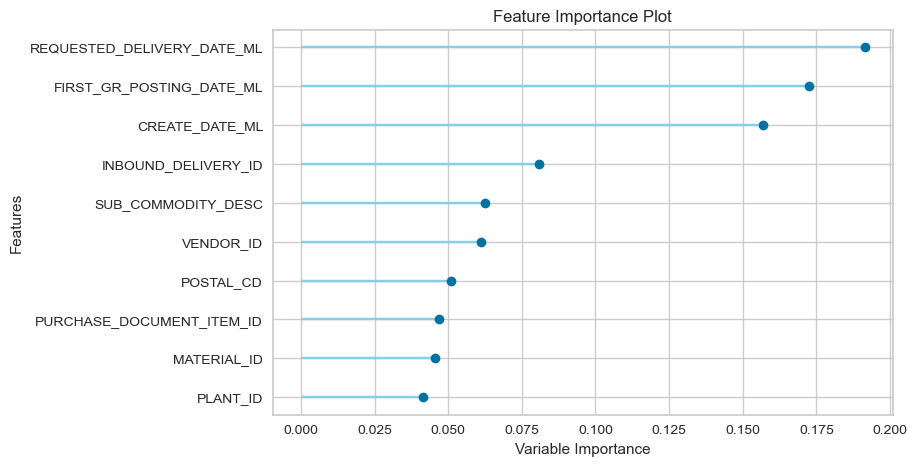

In [16]:
plot_model(rf_model, plot='feature')

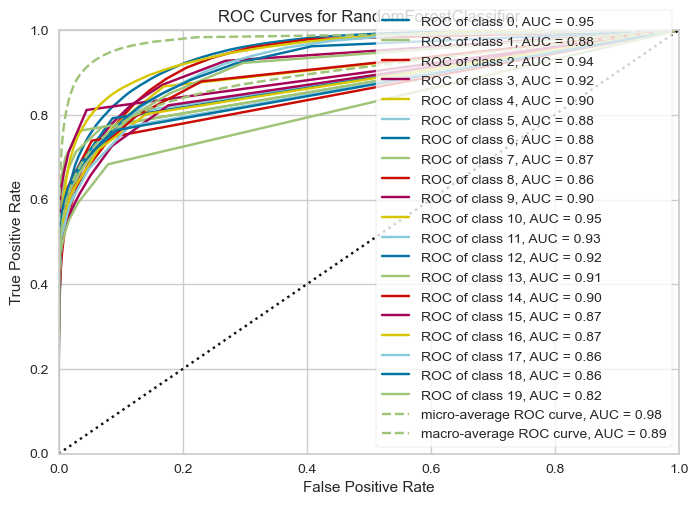

In [18]:
# Area Under the Curve. 
'''
ROC Curve: The ROC curve plots the True Positive Rate (TPR, also known as recall or sensitivity) 
           against the False Positive Rate (FPR) at various threshold settings. The True Positive 
           Rate is the ratio of correctly predicted positive observations to all actual positives, 
           while the False Positive Rate is the ratio of incorrectly predicted positive observations 
           to all actual negatives.
AUC-ROC: The AUC of the ROC curve (AUC-ROC) measures the entire two-dimensional area underneath the 
         entire ROC curve from (0,0) to (1,1). It provides an aggregate measure of the model across 
         all possible classification thresholds. An AUC-ROC value of 1 indicates a perfect model, 
         while a value of 0.5 suggests no discriminative power, equivalent to random guessing.
'''
plot_model(rf_model, plot='auc')

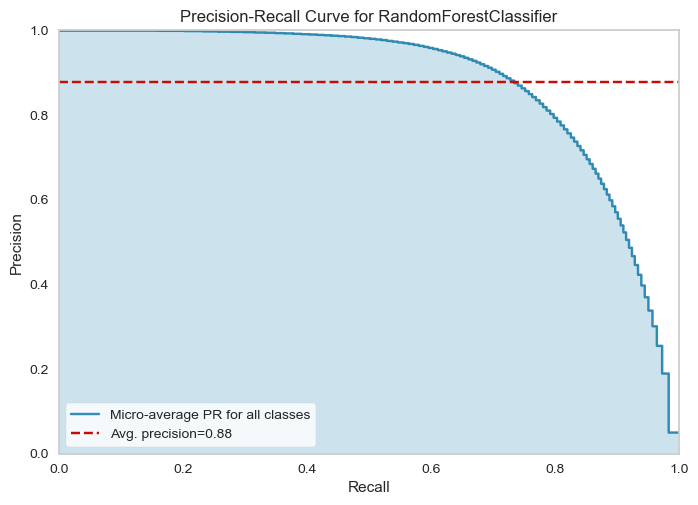

In [19]:
# Precision-Recall (PR) curve 
'''
The Precision-Recall curve is a plot that showcases the trade-off between 
precision (positive predictive value) and recall (sensitivity) for every 
possible threshold of a classification model. It's particularly useful for 
evaluating models on imbalanced datasets where the positive class 
(the class of interest) is much rarer compared to the negative class.

The curve starts at the top-left corner, indicating high precision for low recall values, 
and it typically decreases as recall increases. This is because initially, when the threshold 
for classifying a positive is high, the model is very precise but not very sensitive 
(it doesn't capture many positives). As the threshold is lowered, the model captures more 
true positives, but also more false positives, which decreases precision.

In conclusion, the RandomForestClassifier model shown in the plot has a high average 
precision of 0.88, suggesting it performs well in distinguishing between the positive 
and negative classes for the task at hand. However, the precision decreases as the 
recall increases, which is a typical behavior for most classifiers.
'''
plot_model(rf_model, plot='pr')